# Data Preprocessing and Exploratory Data Analysis (EDA)

This notebook explores the COCO dataset subset, visualizes augmentations, and checks label distributions.

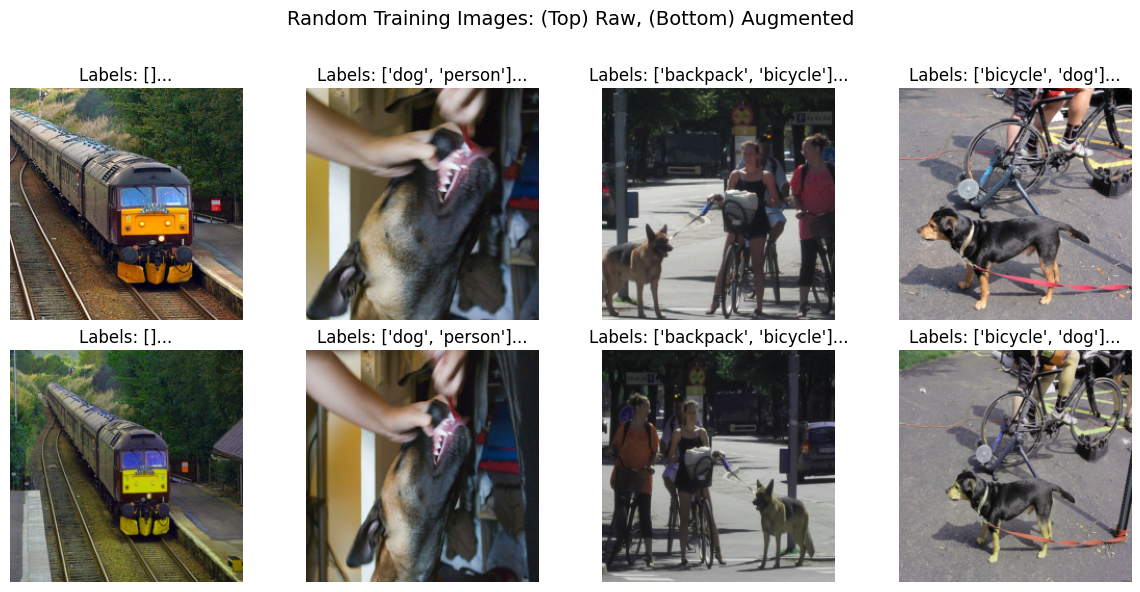

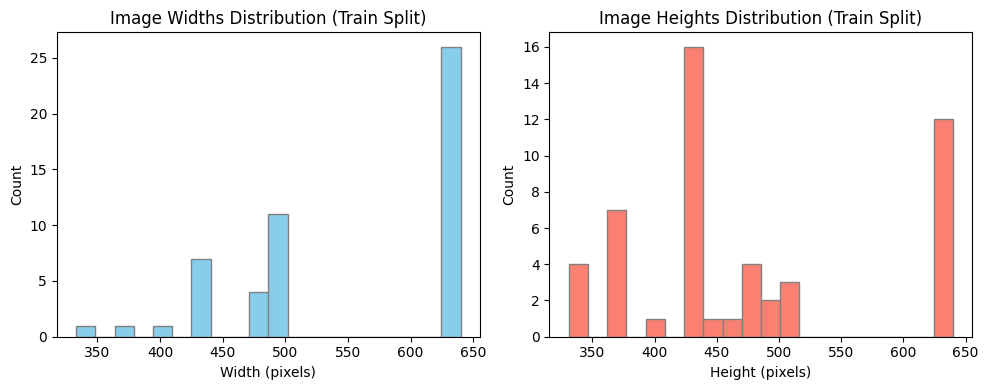

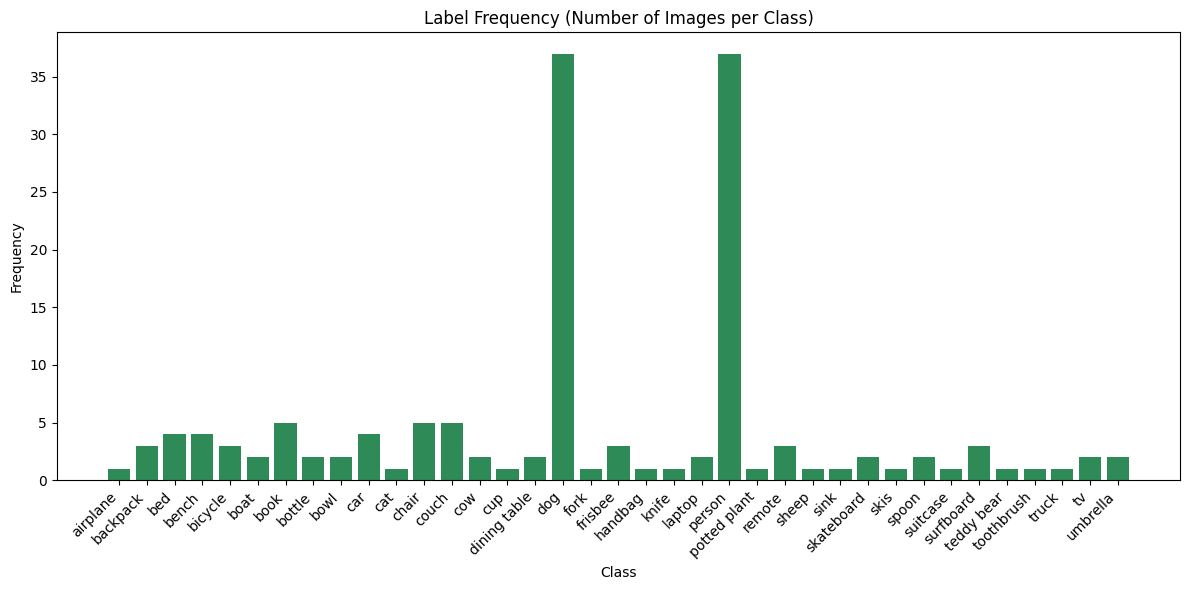

Example multi-hot label vectors (non-zero class indices):
Image 1 (Filename: 000000571342.jpg): Classes = ['cow', 'dog', 'handbag', 'person']
Image 2 (Filename: 000000307073.jpg): Classes = ['dog', 'frisbee', 'person']
Image 3 (Filename: 000000488014.jpg): Classes = ['bicycle', 'dog', 'person']


In [1]:
from pathlib import Path
import sys
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

# Add the project root (parent of src) to sys.path
if "__file__" in globals():
    project_root = Path(__file__).resolve().parent.parent
else:
    project_root = Path().resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
src_parent = project_root.parent
if str(src_parent) not in sys.path:
    sys.path.insert(0, str(src_parent))
from torch.utils.data import DataLoader
from src.data.cocodataset import CocoDataset, collate_fn  # Updated import
from src import config  # Updated import




# Paths to the COCO dataset (adjust these paths as needed)
# These should point to the *exported* data from the data preparation step
base_export_path = Path(config.DATASET_ROOT)
images_dir = str(base_export_path / "train" / "data") # Adjusted path
ann_file = str(base_export_path / "train" / "labels.json") # Adjusted path

# Load two datasets: one without augment (val_transforms) and one with augment (train_transforms)
dataset_raw = CocoDataset(images_dir, ann_file, transform=config.val_transforms)
dataset_aug = CocoDataset(images_dir, ann_file, transform=config.train_transforms)

# Function to denormalize and convert tensor to numpy image for plotting
def tensor_to_image(tensor_img: torch.Tensor):
    img = tensor_img.clone().detach()
    # Use mean and std from the config module
    for t, m, s in zip(img, config.MEAN, config.STD):
        t.mul_(s).add_(m)  # unnormalize
    np_img = img.numpy().transpose((1, 2, 0))
    return np.clip(np_img, 0, 1)

# Plot a few random images: before and after augmentation
if len(dataset_raw) > 0 and len(dataset_aug) > 0: # Check if datasets loaded successfully
    fig, axes = plt.subplots(2, 4, figsize=(12,6))
    fig.suptitle("Random Training Images: (Top) Raw, (Bottom) Augmented", fontsize=14)

    for i in range(4):
        idx = random.randrange(len(dataset_raw))
        sample_raw = dataset_raw[idx]
        sample_aug = dataset_aug[idx]
        if sample_raw is None or sample_aug is None:
            print(f"Skipping corrupted sample at index {idx}")
            continue
        img_raw, label_raw = sample_raw
        img_aug, label_aug = sample_aug

        # Convert tensors to displayable images
        np_raw = tensor_to_image(img_raw)
        np_aug = tensor_to_image(img_aug)

        # Show raw image
        axes[0, i].imshow(np_raw)
        axes[0, i].axis('off')
        # Get class names for labels
        raw_class_indices = label_raw.nonzero().flatten().tolist()
        raw_class_names = [dataset_raw.category_names[j] for j in raw_class_indices]
        axes[0, i].set_title(f"Labels: {raw_class_names[:2]}...") # Show first 2 for brevity

        # Show augmented image
        axes[1, i].imshow(np_aug)
        axes[1, i].axis('off')
        aug_class_indices = label_aug.nonzero().flatten().tolist()
        aug_class_names = [dataset_aug.category_names[j] for j in aug_class_indices]
        axes[1, i].set_title(f"Labels: {aug_class_names[:2]}...") # Show first 2 for brevity


    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()
else:
    print("Datasets are empty. Cannot plot images. Check data paths and preparation.")


# Histogram of original image widths and heights
# This part still uses the original COCO annotation structure if available,
# or you might need to adapt it if you only have the exported labels.json
# For simplicity, let's assume the original ann_file for metadata is still accessible,
# or this part is adapted to use dataset_raw.id_to_filename and PIL to get dimensions.
# If using the exported labels.json, it might not contain width/height directly in 'images'.
# The FiftyOne export to COCO format *should* include this.
try:
    with open(ann_file, 'r') as f: # Using the train split's labels.json
        coco_data = json.load(f)
    if 'images' in coco_data and coco_data['images']:
        widths = [img['width'] for img in coco_data['images']]
        heights = [img['height'] for img in coco_data['images']]

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.hist(widths, bins=20, color='skyblue', edgecolor='gray')
        plt.title('Image Widths Distribution (Train Split)')
        plt.xlabel('Width (pixels)'); plt.ylabel('Count')

        plt.subplot(1,2,2)
        plt.hist(heights, bins=20, color='salmon', edgecolor='gray')
        plt.title('Image Heights Distribution (Train Split)')
        plt.xlabel('Height (pixels)'); plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    else:
        print("Image dimension data not found or empty in train labels.json.")
except FileNotFoundError:
    print(f"Annotation file {ann_file} not found for image dimension analysis.")
except Exception as e:
    print(f"Could not plot image dimensions: {e}")


# Compute and plot label frequency across dataset
if len(dataset_raw) > 0:
    # Stack all label vectors into one tensor
    all_labels = torch.stack(dataset_raw.labels)
    label_counts = all_labels.sum(dim=0).numpy()
    category_names = dataset_raw.category_names

    plt.figure(figsize=(12,6)) # Increased figure size for better readability
    plt.bar(np.arange(len(label_counts)), label_counts, color='seagreen')
    plt.title('Label Frequency (Number of Images per Class)')
    plt.xlabel('Class'); plt.ylabel('Frequency')
    plt.xticks(np.arange(len(category_names)), category_names, rotation=45, ha="right") # Use category names for x-ticks
    plt.tight_layout()
    plt.show()

    # Print a few example label vectors to verify encoding
    print("Example multi-hot label vectors (non-zero class indices):")
    for i in range(min(3, len(dataset_raw))): # Ensure we don't go out of bounds
        label_vec = dataset_raw.labels[i]
        classes = [dataset_raw.category_names[j] for j in (label_vec.nonzero().flatten().tolist())]
        print(f"Image {dataset_raw.image_ids[i]} (Filename: {dataset_raw.id_to_filename[dataset_raw.image_ids[i]]}): Classes = {classes}")
else:
    print("Dataset_raw is empty. Cannot compute label frequencies or show examples.")


In [ ]:
# Export notebook to HTML

# Add this tag to the cell metadata to exclude it from exports
# Add the following to the cell metadata: {"tags": ["remove_cell"]}

import nbformat
from nbconvert import HTMLExporter
import os

# Get the current notebook name
notebook_path = "02_preprocessing_eda.ipynb"
html_path = notebook_path.replace(".ipynb", ".html")

# Load the notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Create HTMLExporter
html_exporter = HTMLExporter()
html_exporter.exclude_tag_names = ['remove']  # This will exclude cells with 'remove_cell' tag

# Convert to HTML
(body, resources) = html_exporter.from_notebook_node(notebook)

# Write to HTML file
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(body)

print(f"Notebook exported to {html_path}")

FileNotFoundError: [Errno 2] No such file or directory: '02_preprocessing.ipynb'